In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from IPython.display import clear_output, display

In [2]:
def draw_lattice_with_hotspots(species, hotspots, wall=None, hex_radius=1, ax=None):
    rows, cols = species.shape
    hex_width = np.sqrt(3) * hex_radius
    hex_height = 2 * hex_radius
    angles = np.linspace(np.pi / 6, 2 * np.pi + np.pi / 6, 7)
    hex_x = hex_radius * np.cos(angles)
    hex_y = hex_radius * np.sin(angles)
    
    # Generate hexagon coordinates
    x_indices, y_indices = np.meshgrid(np.arange(rows), np.arange(cols))
    center_x = x_indices * hex_width + (y_indices % 2) * (hex_width / 2)
    center_y = -(rows - 1 - y_indices) * (3 / 4 * hex_height) # grow from the bottom
    hex_centers = np.column_stack((center_x.flatten(), center_y.flatten()))
    hex_vertices = np.array([np.column_stack((hex_x + cx, hex_y + cy)) for cx, cy in hex_centers])
    # Colors for species
    color_map = {0: "white", 1: "red", 2: "yellow"}
    face_colors = np.array([color_map[species[i, j]] for i in range(rows) for j in range(cols)])
    hotspot_mask = hotspots.flatten() == 1
    edge_colors="none" if np.sqrt(rows*cols) >= 100 else "black"

    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    # Regular hexagons
    ax.add_collection(PolyCollection(
        verts=hex_vertices,
        facecolors=face_colors,
        edgecolors=edge_colors
    ))
    # Hotspot hexagons with transparency
    ax.add_collection(PolyCollection(
        verts=hex_vertices[hotspot_mask],
        facecolors="black",
        edgecolors=edge_colors,
        alpha=0.4  # 50% transparency for hotspots
    ))
    # Highlight the domain wall with thick edges
    if wall is not None:
        wall_indices = np.array(wall)  # List of (i, j) indices
        wall_vertices = [hex_vertices[i * cols + j] for i, j in wall_indices]
        ax.add_collection(PolyCollection(
            verts=wall_vertices,
            facecolors="blue",
            edgecolors=edge_colors,  # Color for the wall
            # linewidths=1.5  # Thickness of the wall edges
            alpha = 0.8
        ))
    ax.set_xlim(center_x.min() - hex_radius, center_x.max() + hex_radius)
    ax.set_ylim(center_y.min() - hex_radius, center_y.max() + hex_radius)
    ax.set_aspect('equal')
    ax.axis('off')
    if ax is None: plt.show()

In [3]:
def generate_hotspots(form, Ra, Rb, phi):
    rows, cols = form.shape
    lattice = np.zeros((rows, cols), dtype=int)
    num_hotspots = int( phi * rows*cols / (1+3*Ra*(Rb+1)) )
    # generate random hotspot centers
    cx = np.random.randint(0, rows, size=num_hotspots)
    cy = np.random.randint(0, cols, size=num_hotspots)
    hotspot_centers = list(zip(cx, cy))    
    # Convert (row, col) to axial coordinates
    def to_axial(row, col):
        q = col - (row // 2)  # adjust column based on row parity
        r = row
        return q, r
    # convert axial back to (row, col)
    def to_real(q, r):
        col = q + (r // 2)
        row = r
        return row, col
    # fill the lattice based on radius R
    for cx, cy in hotspot_centers:
        center_q, center_r = to_axial(cx, cy)
        for dq in range(-Ra, Ra + 1):
            for dr in range(-Rb, Rb + 1):
                # calculate hexagonal distance
                #if abs(dq) + abs(dr) + abs(-dq - dr) <= Ra:
                if (dq / Ra) ** 2 + (dr / Rb) ** 2 + ((dq + dr)/Ra) **2  <= 1:
                # if dq*dq/(R*R) + dr*dr/(R*R) <= R:
                    row, col = to_real(center_q + dq, center_r + dr )
                    if 0 <= row < rows and 0 <= col < cols:  # boundary check
                        lattice[row, col] = 1
    return lattice

In [4]:
def track_domain_wall(lattice, prev_wall=None):
    rows, cols = lattice.shape
    directions_odd = [(-1,  0), (-1, +1), (0, -1), (0, +1), (+1,  0), (+1, +1)]
    directions_even = [(-1, -1), (-1,  0), (0, -1), (0, +1), (+1, -1), (+1,  0)]
    new_wall = set()  # use a set to avoid duplicates
    if prev_wall is None:
        for j in range(cols):
            if lattice[0, j] > 0:
                new_wall.add((0, j))
    else:
        # only explore neighbors of the previous wall
        for i, j in prev_wall:
            directions = directions_even if i % 2 == 0 else directions_odd
            for dr, dc in directions:
                ni, nj = i + dr, j + dc
                if 0 <= ni < rows and 0 <= nj < cols:
                    if lattice[ni, nj] == 0:
                        new_wall.add((i, j)) # no update
                    else:
                        """ Check if this occupied cell has at least one unoccupied neighbor
                            Note that algorithm updates at most all neighbors of previous wall sites cell per iteration """
                        neighbor_directions = directions_even if ni % 2 == 0 else directions_odd
                        for ddr, ddc in neighbor_directions:
                            nni, nnj = ni + ddr, nj + ddc
                            if 0 <= nni < rows and 0 <= nnj < cols and lattice[nni, nnj] == 0:
                                new_wall.add((ni, nj))
    return list(new_wall)

In [5]:
def update_with_wall_tracking(lattice, hotspots, wall, params, nu, mu):
    rows, cols = lattice.shape
    # choose a random cell from the domain wall
    i, j = wall[np.random.randint(len(wall))]
    directions_odd = [(-1,  0), (-1, +1), (0, -1), (0, +1), (+1,  0), (+1, +1)]
    directions_even = [(-1, -1), (-1,  0), (0, -1), (0, +1), (+1, -1), (+1,  0)]
    directions = directions_even if i % 2 == 0 else directions_odd
    flavor = lattice[i, j]
    if flavor > 0:
        growth = (1+nu)*params[flavor] if hotspots[i, j] == 1 else params[flavor]
        for dr, dc in directions:
            ni, nj = i + dr, j + dc
            if 0 <= ni < rows and 0 <= nj < cols:  # boundary check
                if lattice[ni, nj] == 0:
                    if random.random() <= growth: # success in growth
                        if flavor == 1: # wild
                            if mu == 0:
                                lattice[ni, nj] = 1
                            else:
                                if random.random() <= mu: # mutate
                                    lattice[ni, nj] = 2
                                else:
                                    lattice[ni, nj] = 1
                        elif flavor == 2: # mutant
                            lattice[ni, nj] = 2
    return lattice

In [6]:
def update_with_wall_tracking_fixed(lattice, hotspots, wall, params, nu, mu):
    rows, cols = lattice.shape
    # choose a random cell from the domain wall
    i, j = wall[np.random.randint(len(wall))]
    directions_odd = [(-1,  0), (-1, +1), (0, -1), (0, +1), (+1,  0), (+1, +1)]
    directions_even = [(-1, -1), (-1,  0), (0, -1), (0, +1), (+1, -1), (+1,  0)]
    directions = directions_even if i % 2 == 0 else directions_odd
    flavor = lattice[i, j]
    if flavor > 0:
        growth = (1+nu)*params[flavor] if hotspots[i, j] == 1 else params[flavor]
        dr, dc = directions[np.random.randint(len(directions))]
        ni, nj = i + dr, j + dc
        if 0 <= ni < rows and 0 <= nj < cols and lattice[ni, nj] == 0:  # boundary check
            if random.random() <= growth: # success in growth
                if flavor == 1: # wild
                    if mu == 0:
                        lattice[ni, nj] = 1
                    else:
                        if random.random() <= mu: # mutate
                            lattice[ni, nj] = 2
                        else:
                            lattice[ni, nj] = 1
                elif flavor == 2: # mutant
                    lattice[ni, nj] = 2
    return lattice

In [26]:
L = 32
R = 2
phi = 0.4
mu = 0

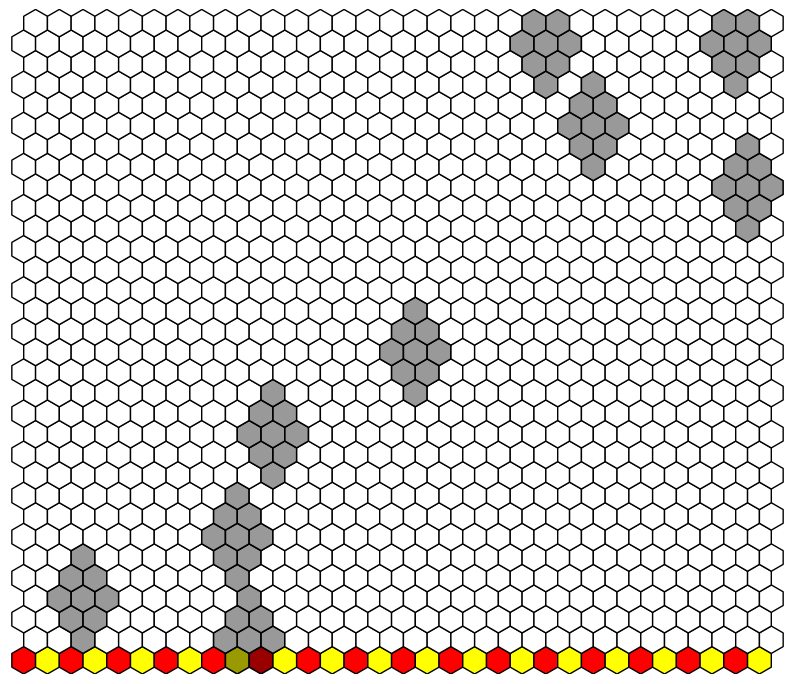

In [28]:
nu = 6
s = 0.05
Gamma_w = 1/(1 + (1+nu) + (1-s) + (1-s)*(1+nu))
Gamma_m = (1-s)*Gamma_w
Gamma = np.array([0, Gamma_w, Gamma_m])
# ininitalize lattice array
k = np.zeros((L,L), dtype=int)
k[0, :] = np.tile([1, 2], L // 2)[:L] # alternating initial condition
hotspots = generate_hotspots(k, R, R+4, phi)
wall = track_domain_wall(k)
draw_lattice_with_hotspots(k, hotspots)

In [ ]:
for i in range(50000):
    k = update_with_wall_tracking_fixed(k, hotspots, wall, Gamma, nu, mu)
    wall = track_domain_wall(k, wall)
draw_lattice_with_hotspots(k, hotspots, wall)

ValueError: high <= 0

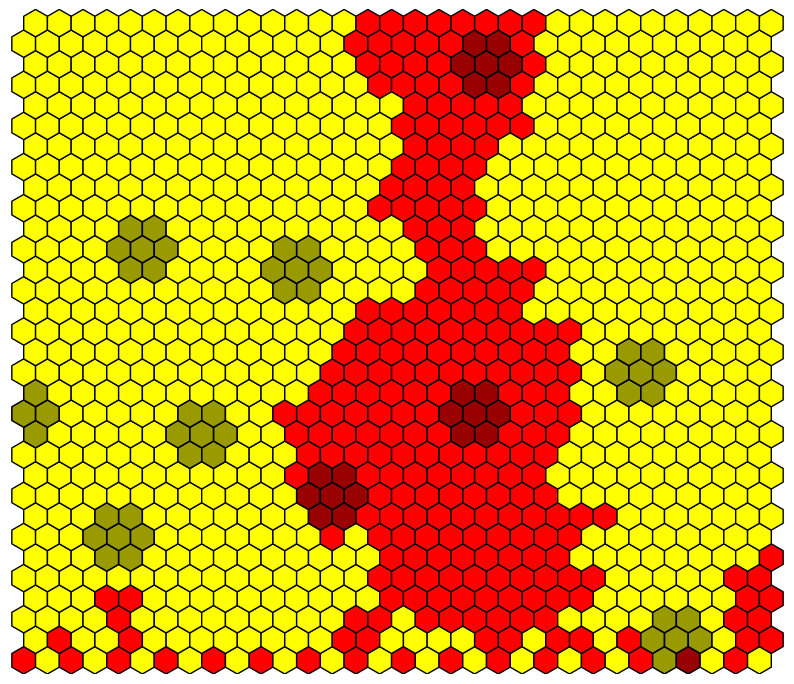

In [24]:
draw_lattice_with_hotspots(k, hotspots)

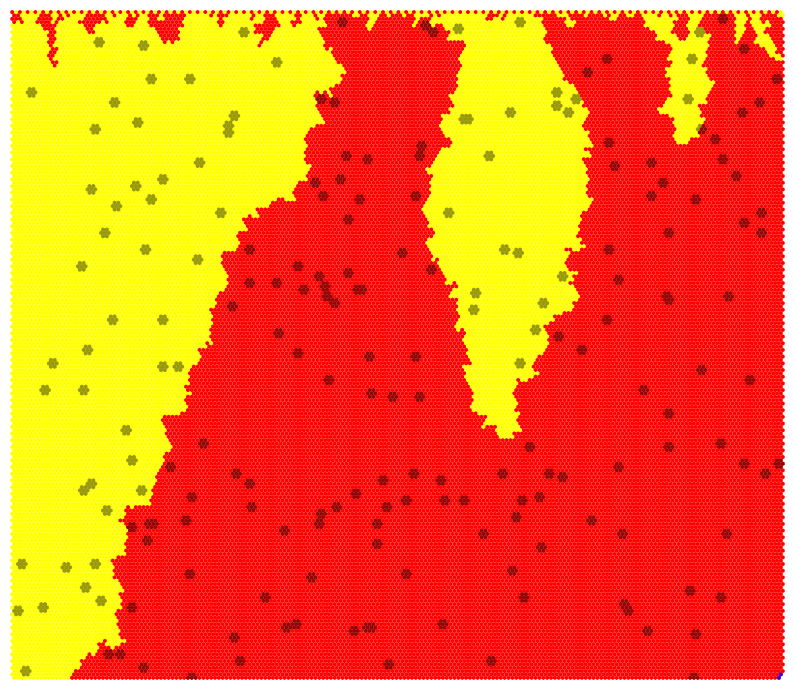

'Iteration: 1769000   Wall Length: 2   Wall mutant ratio: 0.0000'

All species on the domain wall are wild with mu=0. No more updates and simulation terminated.


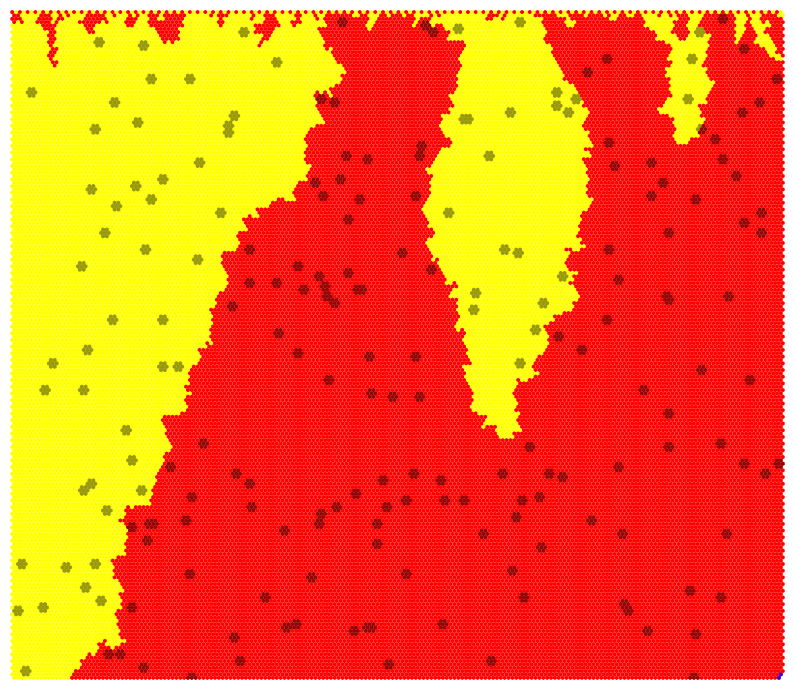

In [21]:
iter = 0
fig, ax = plt.subplots(figsize=(10, 10))
while len(wall) > 0:
    k = update_with_wall_tracking_fixed(k, hotspots, wall, Gamma, nu, mu)
    wall = track_domain_wall(k, wall)
    iter += 1
    if iter % 1000 == 0:
        mutant_ratio = sum(k[i,j]==2 for i, j in wall)/len(wall)
        clear_output(wait=True)     
        # Update the figure
        ax.clear()
        draw_lattice_with_hotspots(k, hotspots, wall=wall, ax=ax)
        display(fig)  # Explicitly display the updated figure
        display(f"Iteration: {iter}   Wall Length: {len(wall)}   Wall mutant ratio: {mutant_ratio:.4f}")
        # check if all species on the wall are wild when mu=0
        if mu == 0 and mutant_ratio == 0: 
            k[k == 0] = 1
            print("All species on the domain wall are wild with mu=0. No more updates and simulation terminated.", flush=True)
            break

1769000


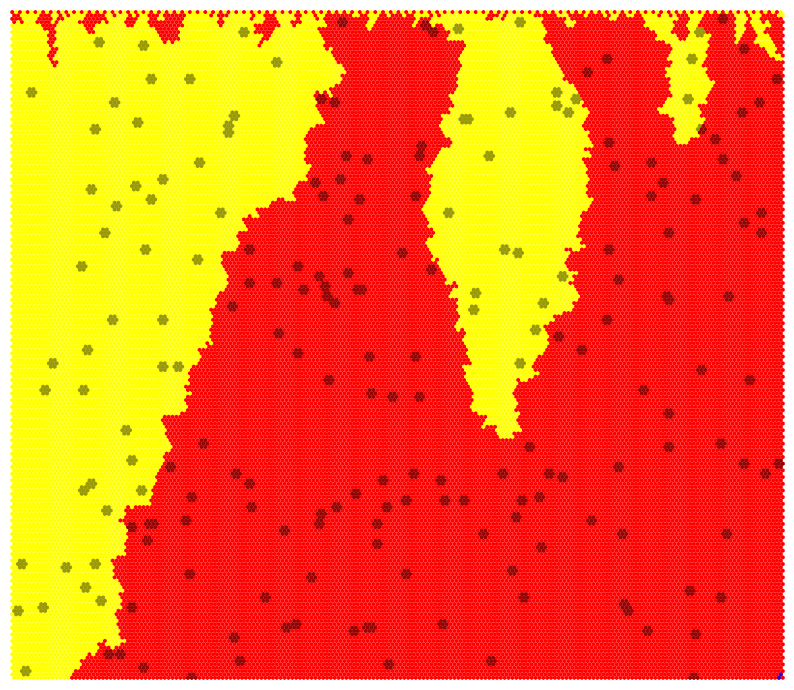

In [22]:
print(iter)
draw_lattice_with_hotspots(k, hotspots, wall) # s = 0.05, nu=6, phi = 0.1, R = 3

17000


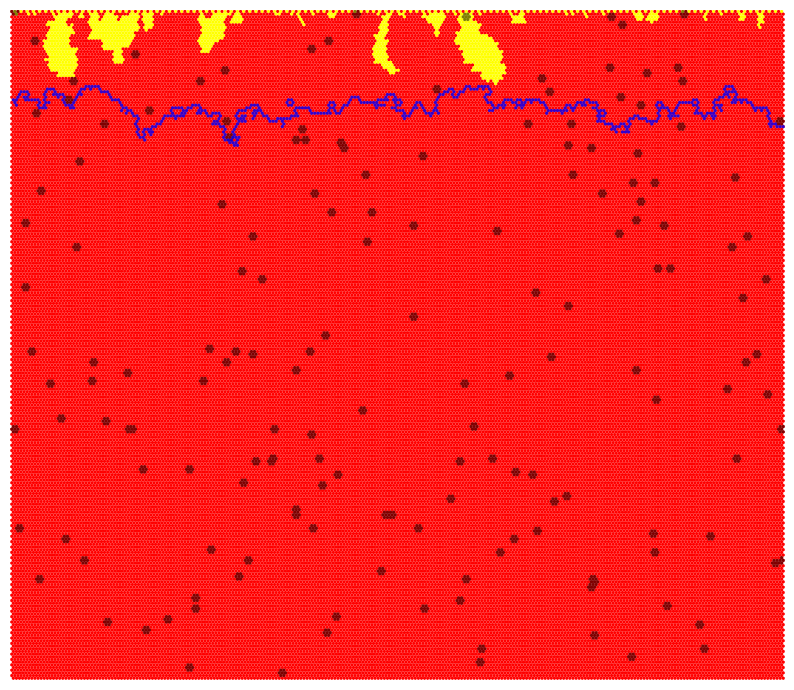

In [12]:
print(iter)
draw_lattice_with_hotspots(k, hotspots, wall) # s = 0.3, phi = 0.1, R = 3

699000


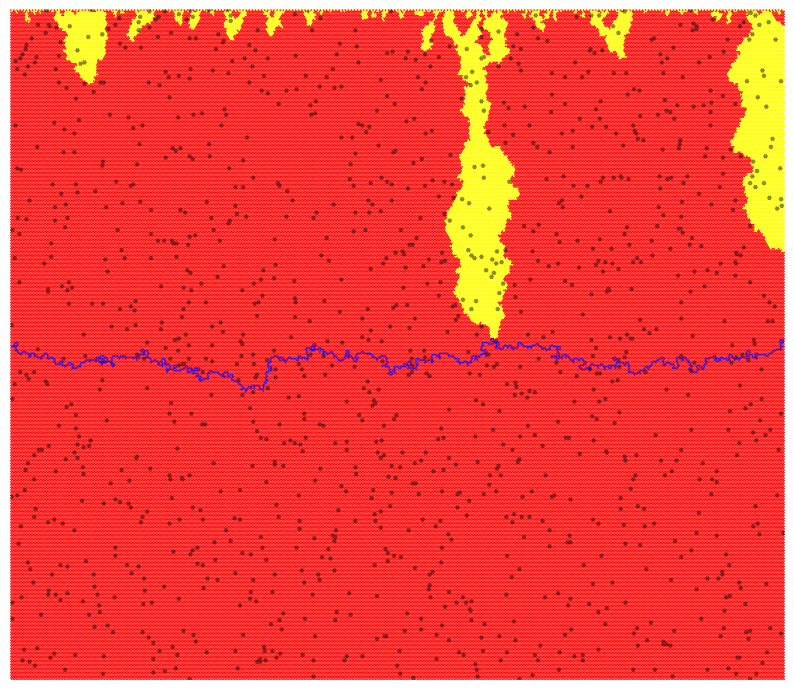

In [182]:
print(iter)
draw_lattice_with_hotspots(k, hotspots, wall) # s = 0.15, phi = 0.1

51000


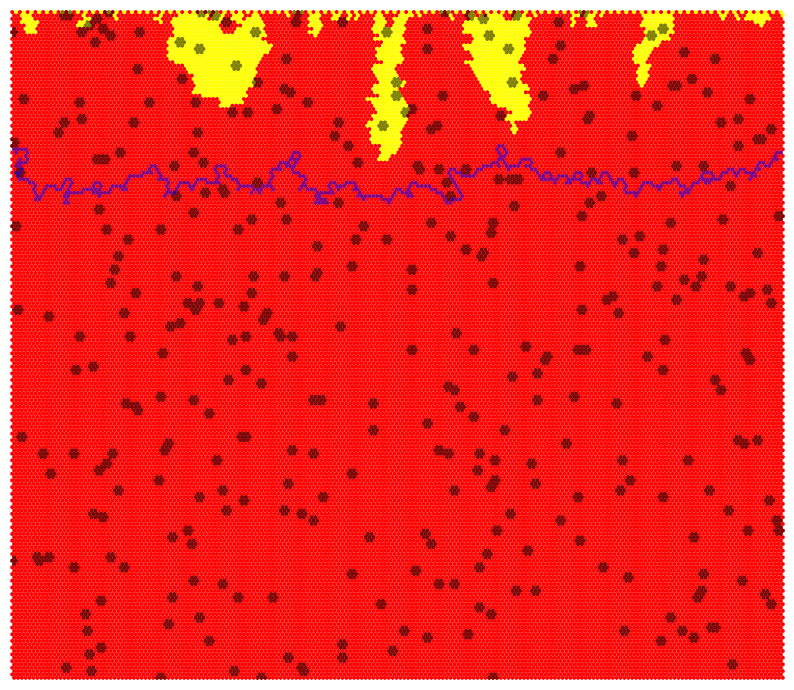

In [167]:
print(iter)
draw_lattice_with_hotspots(k, hotspots, wall) # s = 0.3, phi = 0.35

103000


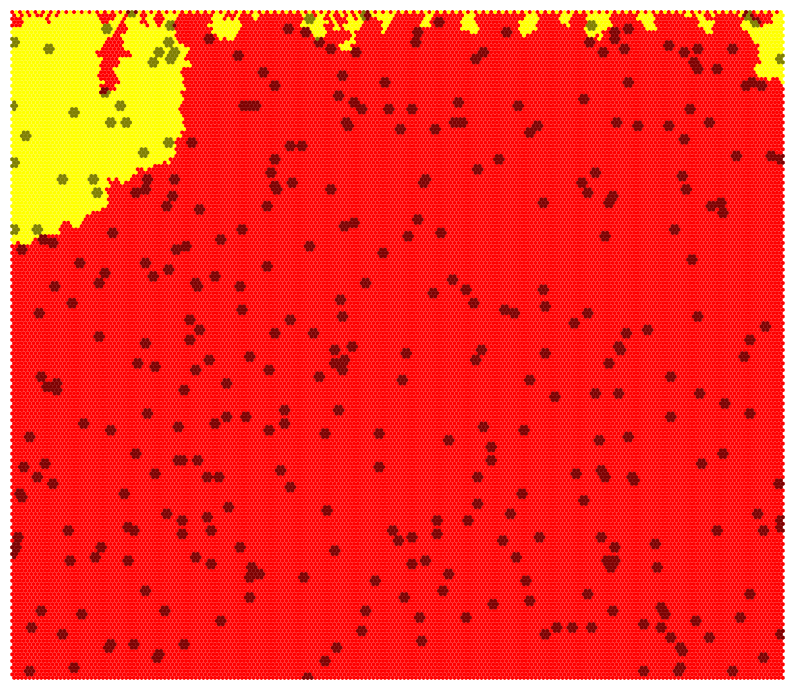

In [135]:
print(iter)
draw_lattice_with_hotspots(k, hotspots) # s = 0.3, phi = 0.35

90000


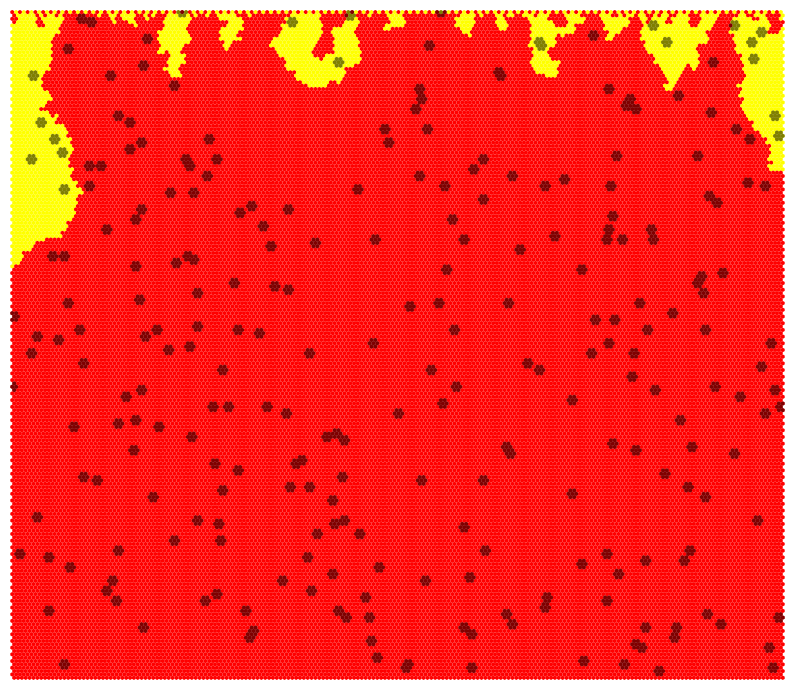

In [122]:
print(iter)
draw_lattice_with_hotspots(k, hotspots) # s = 0.2

208558


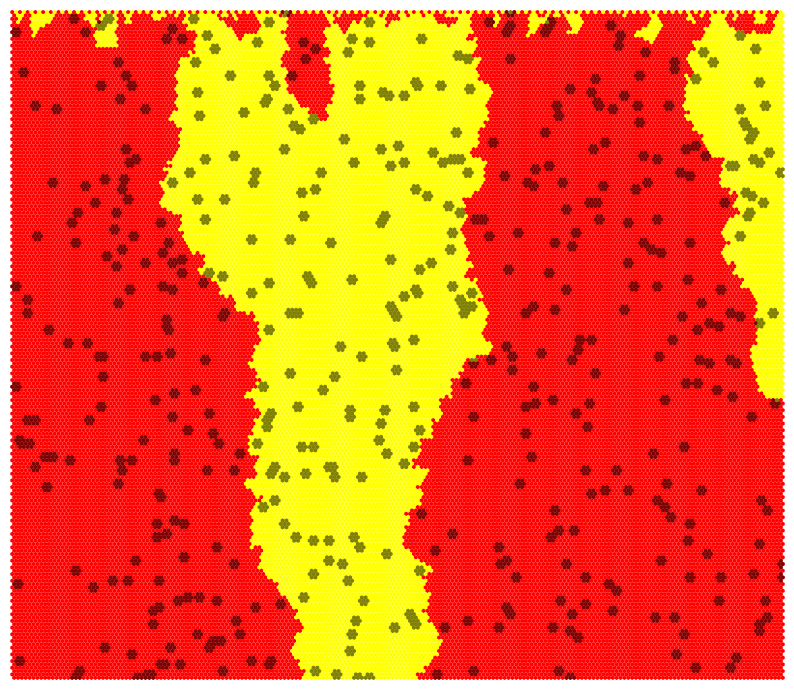

In [110]:
print(iter)
draw_lattice_with_hotspots(k, hotspots) # s = 0.1

6704


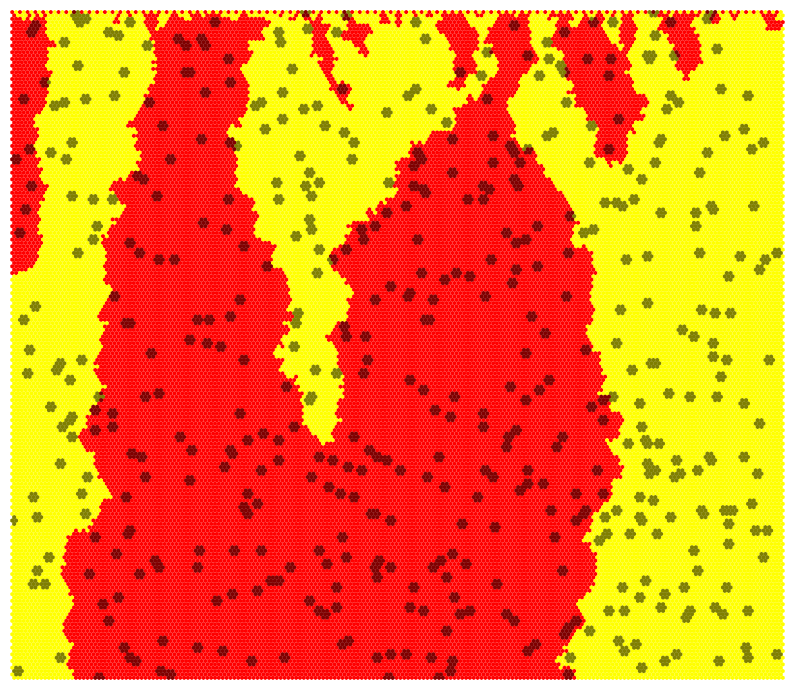

In [107]:
print(iter)
draw_lattice_with_hotspots(k, hotspots) # s = 0

202000


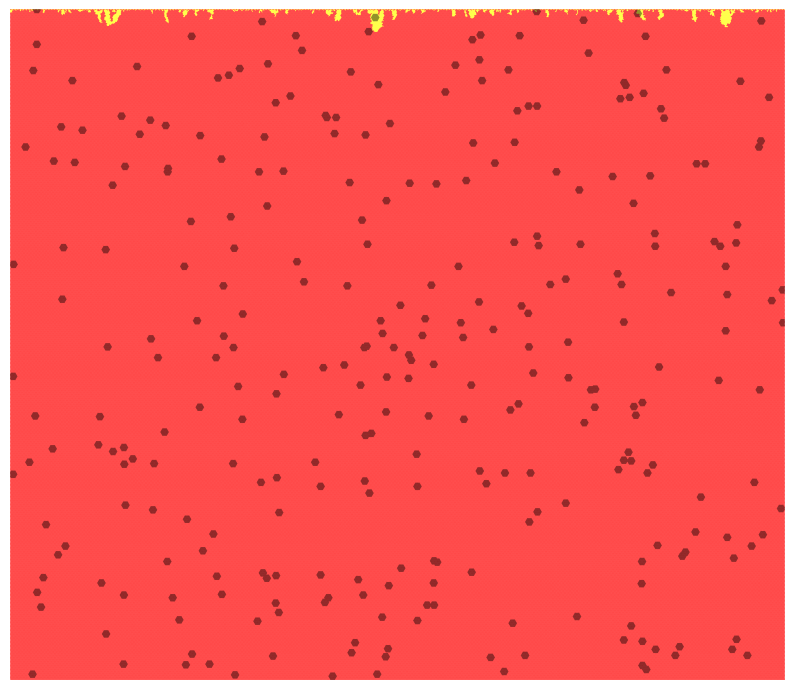

In [52]:
print(iter)
draw_lattice_with_hotspots(k, hotspots)

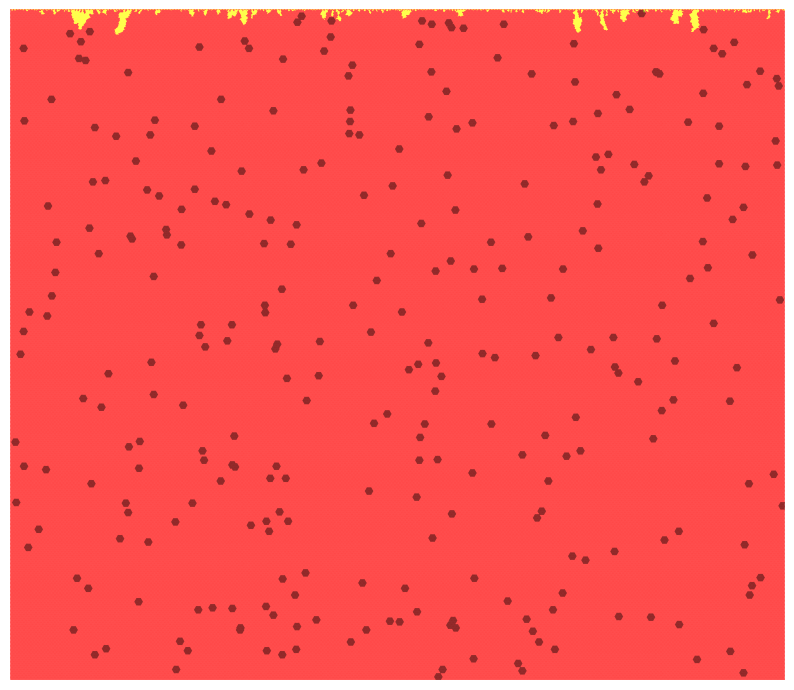

In [23]:
draw_lattice_with_hotspots(k, hotspots)

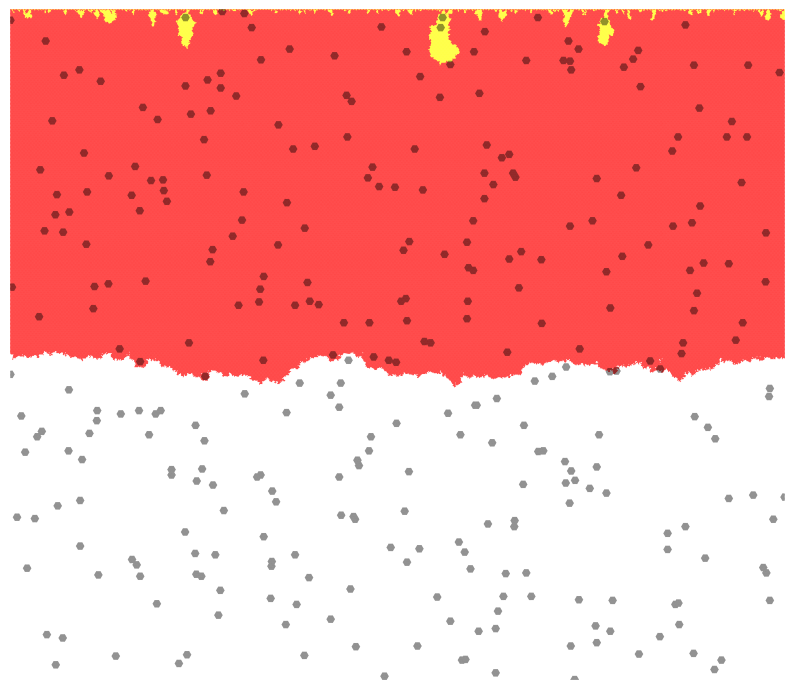

In [11]:
draw_lattice_with_hotspots(k, hotspots)

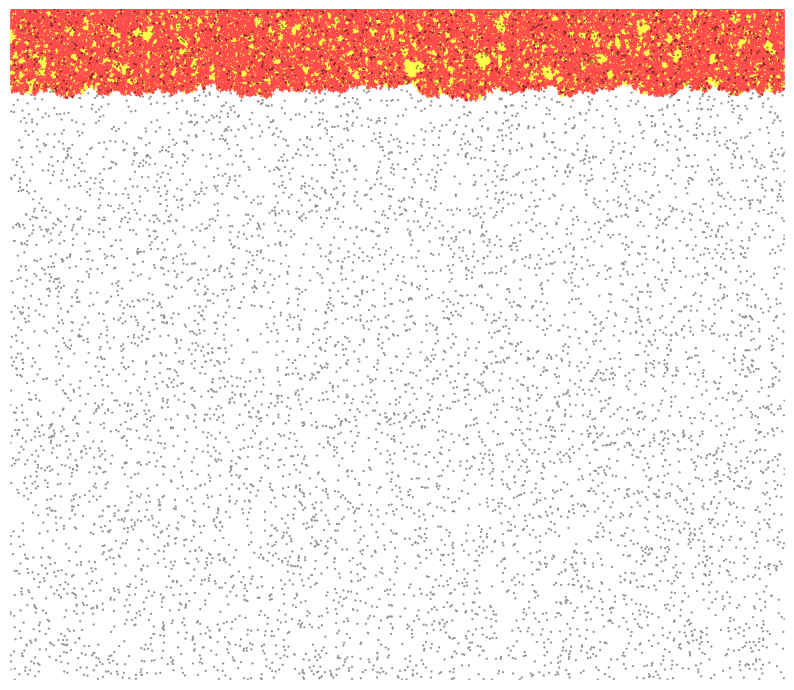

In [19]:
save_k = k
save_kh = hotspots

draw_lattice_with_hotspots(save_k, save_kh, 1)

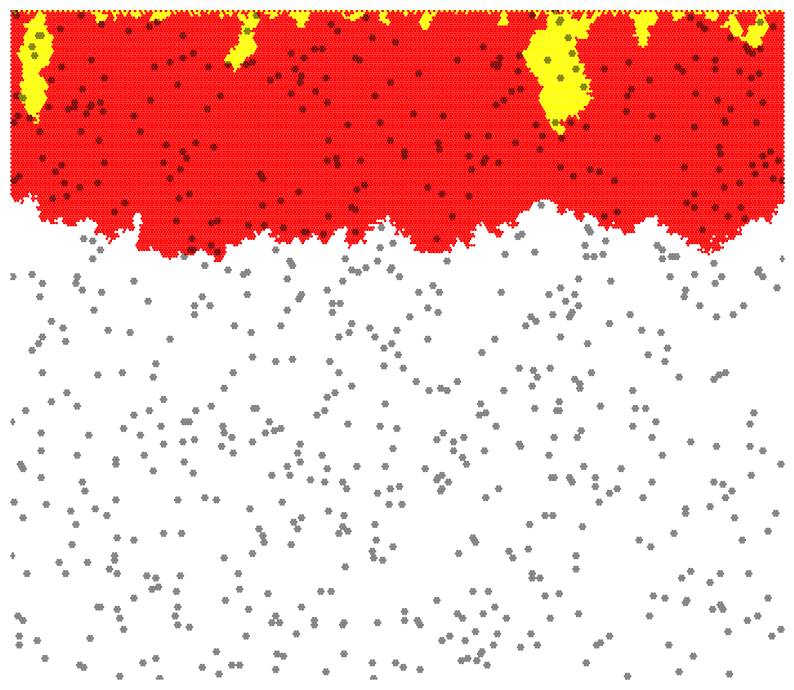

In [54]:
draw_lattice_with_hotspots(k, hotspots)